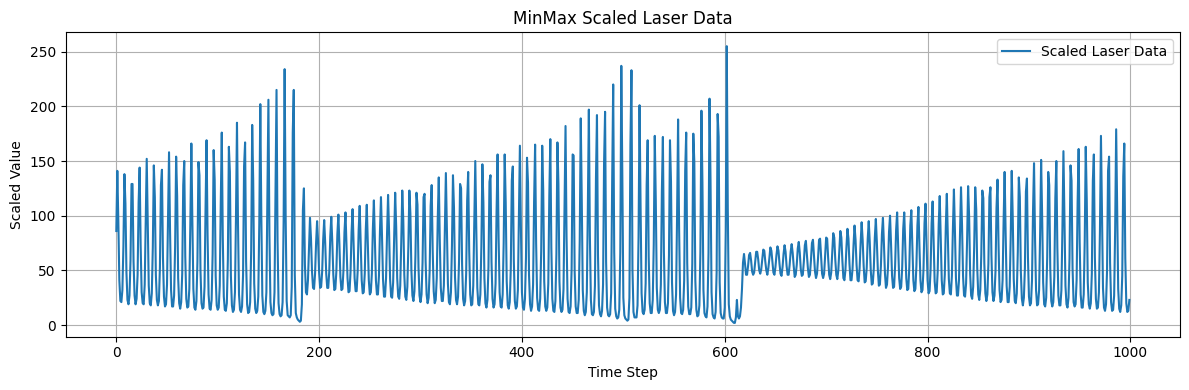

In [45]:
import torch
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

data = loadmat('Xtrain.mat')
train_data = data['Xtrain']
train_data = train_data.squeeze()

scaler = MinMaxScaler()
#Scale data between [0,1]
scaled_data = scaler.fit_transform(train_data.reshape(-1, 1)).squeeze()


# Plot the scaled data
plt.figure(figsize=(12, 4))
plt.plot(train_data, label="Scaled Laser Data")
plt.title("MinMax Scaled Laser Data")
plt.xlabel("Time Step")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
#How many previous datapoints should be considered
input_len = 100

X, Y = [], []

#For the whole lader sequence generate corresponding data points. X is the first input_len of numbers, Y is the one after. 
#Loop over the whole laser sequence
for i in range(len(scaled_data) - input_len - 1):
    X.append(scaled_data[i:i + input_len])
    Y.append(scaled_data[i + input_len])

X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  
Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(-1)  


In [50]:
import torch.nn as nn

#Define LSTM model
class LSTMOneStep(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1]) 
        return out


Fold 1
Validation Loss: 0.0048


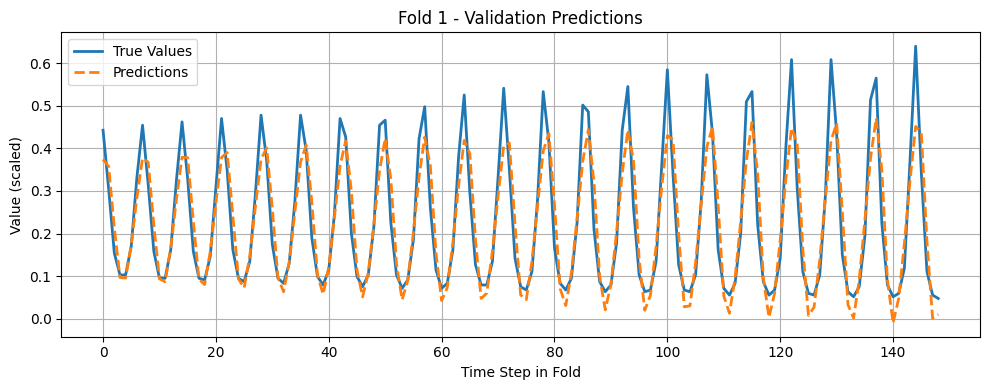


Fold 2
Validation Loss: 0.0081


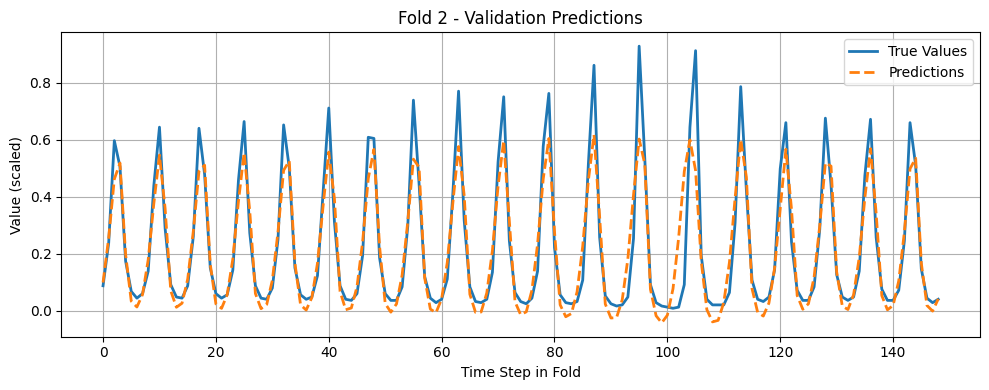


Fold 3
Validation Loss: 0.0094


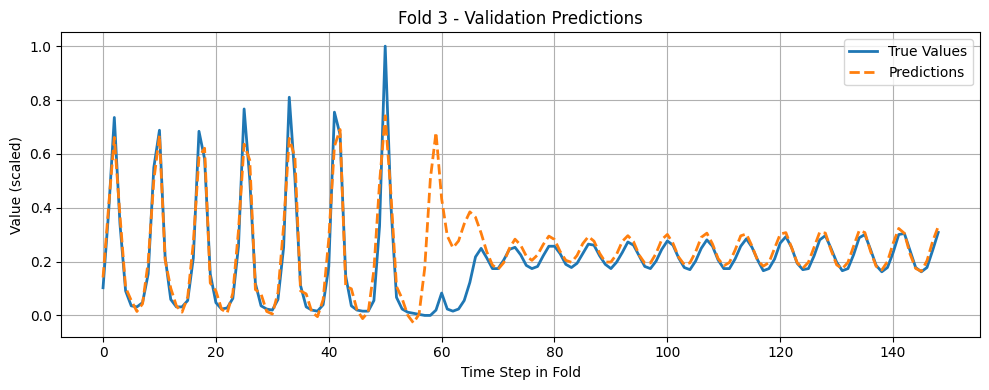


Fold 4
Validation Loss: 0.0006


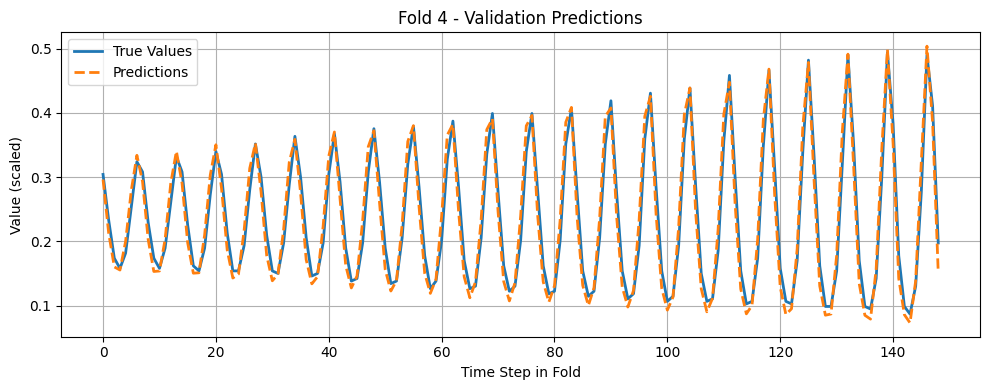


Fold 5
Validation Loss: 0.0010


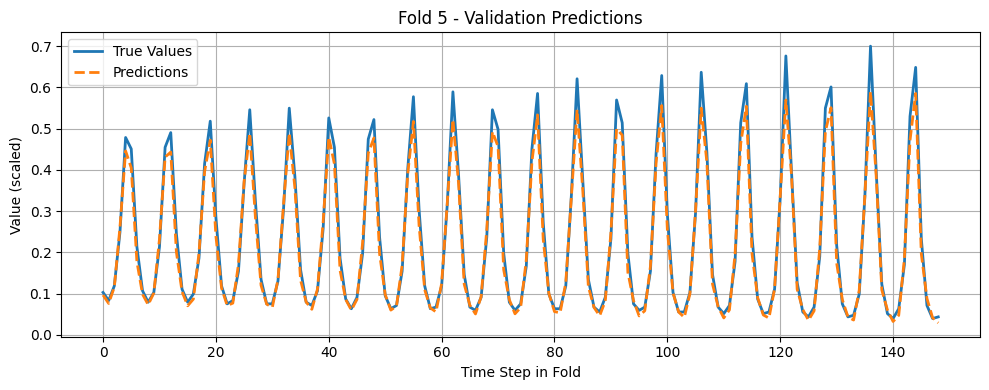

In [52]:
from sklearn.model_selection import TimeSeriesSplit
import torch

tscv = TimeSeriesSplit(n_splits=5)

epochs = 50

# Convert full dataset to NumPy arrays
X_np = X.squeeze(-1).numpy()  # shape [samples, seq_len]
Y_np = Y.numpy()              # shape [samples, 1]

losses_per_fold = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_np)):
    print(f"\nFold {fold+1}")
    
    # Split into training and validation sets
    X_train = torch.tensor(X_np[train_idx], dtype=torch.float32).unsqueeze(-1)
    Y_train = torch.tensor(Y_np[train_idx], dtype=torch.float32)
    X_val = torch.tensor(X_np[val_idx], dtype=torch.float32).unsqueeze(-1)
    Y_val = torch.tensor(Y_np[val_idx], dtype=torch.float32)

    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, Y_train), batch_size=32, shuffle=False)
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_val, Y_val), batch_size=32, shuffle=False)

    # Re-initialize model for each fold
    model = LSTMOneStep()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.MSELoss()

    # Train
    for epoch in range(epochs):  
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_losses.append(loss.item())
    avg_val_loss = sum(val_losses) / len(val_losses)
    losses_per_fold.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    # Collect predictions and targets for plotting
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            all_preds.extend(pred.squeeze().numpy())
            all_targets.extend(yb.squeeze().numpy())

    # Plot predictions vs ground truth
    plt.figure(figsize=(10, 4))
    plt.plot(all_targets, label='True Values', linewidth=2)
    plt.plot(all_preds, label='Predictions', linewidth=2, linestyle='--')
    plt.title(f'Fold {fold+1} - Validation Predictions')
    plt.xlabel("Time Step in Fold")
    plt.ylabel("Value (scaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

